In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

### Load Data

In [2]:
train_dir = './train'
batch_size = 32
img_height = 240
img_width = 240

IMAGE_SIZE = (img_width, img_height)
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(img_width,img_height),
subset='training')

valid_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =(img_width,img_height),
subset='validation')

Found 711 files belonging to 3 classes.
Using 569 files for training.
Found 711 files belonging to 3 classes.
Using 142 files for validation.


In [67]:
test_dir = './test'
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True,batch_size=batch_size, image_size=(img_width,img_height))

Found 114 files belonging to 3 classes.


### Explore Data

In [5]:
class_names = train_set.class_names
print(class_names)

['adidas', 'converse', 'nike']


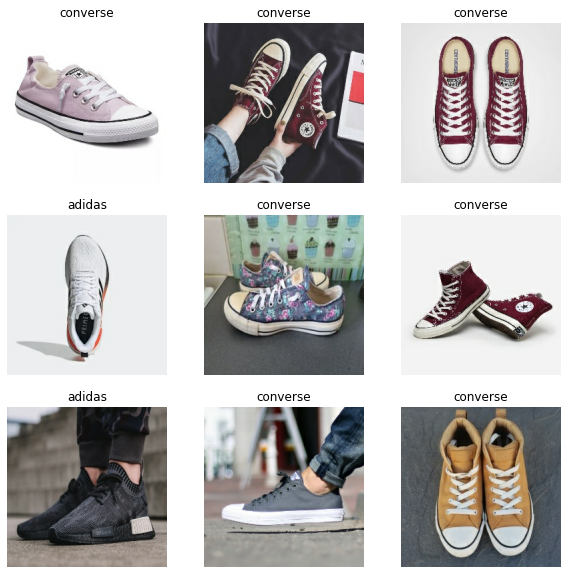

In [6]:
plt.figure(figsize=(10, 10))
for images,labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [8]:
for test_image_batch, test_labels_batch in test_set:
  print(test_image_batch.shape)
  print(test_labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


### Data Augmentation

In [9]:
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                               tf.keras.layers.RandomRotation(0.2),
                               tf.keras.layers.RandomZoom(0.1)])

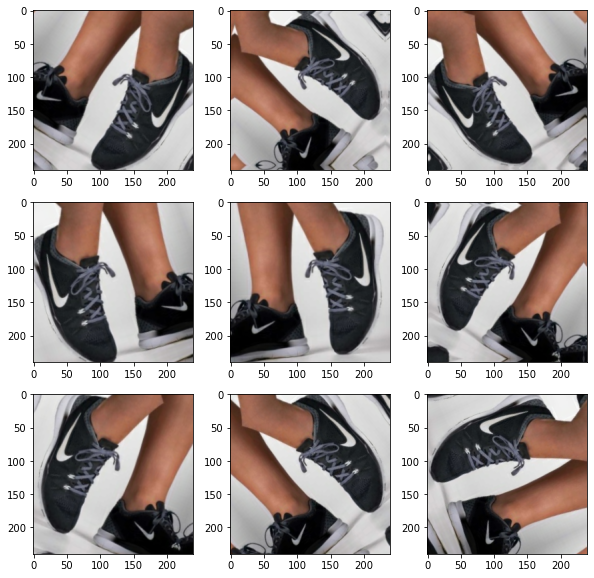

In [10]:
for image, _ in train_set.take(1):
    plt.figure(figsize=(10, 10))
    img = image[16]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augment(tf.expand_dims(img, 0))
        plt.imshow(augmented_image[0] / 255)

### Preprocess the Model
* As we are using a pre-trained model, the mobilenet_v2 expects our images to be normalized i.e. the pixel values should be in between [0, 255], so we will use the preprocess_input method of the mobilenet model to preprocess our data.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Base Model

In [12]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 60, 60, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 61, 61, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 30, 30, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 30, 30, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 15, 15, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 15, 15, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 15, 15, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 15, 15, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 15, 15, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 15, 15, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 15, 15, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 15, 15, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

**Observed that the last layer is the activation layers because we exclude the dense layer using** `include_top = False`

In [14]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 8, 8, 1280])

### Freeze the convolutional base

In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 60, 60, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 61, 61, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 30, 30, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 30, 30, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 15, 15, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 15, 15, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 15, 15, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 15, 15, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 15, 15, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 15, 15, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 15, 15, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 15, 15, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

**Observed that trainable parameters = 0 due to freezing (no weight update) using** `base_model.trainable = False`

In [17]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 8, 8, 1280])

### Add a classification head
* using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


* Apply a `tf.keras.layers.Dense` layer with **3** neurons because we have 3 classes to convert these features into a single prediction per image.

In [19]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


* Build a model by chaining together the data augmentation, rescaling, **base_model** and feature extractor layers using the Keras Functional API. As previously mentioned, use `training=False` as our model contains a BatchNormalization layer.

In [20]:
# inputs with shape argument
inputs = tf.keras.Input(shape=(240, 240, 3))

# Data Augmentation
x = data_augment(inputs)

# Preprocessing (Normalizing) the data
x = preprocess_input(x)

# Freezing the layers
x = base_model(x, training=False)

# Global average pooling to reduce dimensions
x = global_average_layer(x)

# Dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

### Compile the model

In [21]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

### Train the model

In [23]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(valid_set)

5/5 [==============================] - 6s 757ms/step - loss: 1.2290 - accuracy: 0.3239


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.23
initial accuracy: 0.32


In [25]:
history = model.fit(train_set,
                    epochs=initial_epochs,
                    validation_data=valid_set)

Epoch 1/50
18/18 [==============================] - 28s 1s/step - loss: 1.2280 - accuracy: 0.3673 - val_loss: 1.1873 - val_accuracy: 0.4155
Epoch 2/50
18/18 [==============================] - 23s 1s/step - loss: 1.0741 - accuracy: 0.4780 - val_loss: 1.0994 - val_accuracy: 0.4437
Epoch 3/50
18/18 [==============================] - 23s 1s/step - loss: 0.9846 - accuracy: 0.4921 - val_loss: 1.0271 - val_accuracy: 0.4577
Epoch 4/50
18/18 [==============================] - 24s 1s/step - loss: 0.9266 - accuracy: 0.5413 - val_loss: 0.9885 - val_accuracy: 0.4718
Epoch 5/50
18/18 [==============================] - 24s 1s/step - loss: 0.8669 - accuracy: 0.5747 - val_loss: 0.9440 - val_accuracy: 0.5352
Epoch 6/50
18/18 [==============================] - 23s 1s/step - loss: 0.8078 - accuracy: 0.6327 - val_loss: 0.9196 - val_accuracy: 0.5423
Epoch 7/50
18/18 [==============================] - 23s 1s/step - loss: 0.8094 - accuracy: 0.6362 - val_loss: 0.8847 - val_accuracy: 0.5563
Epoch 8/50
18/18 [==

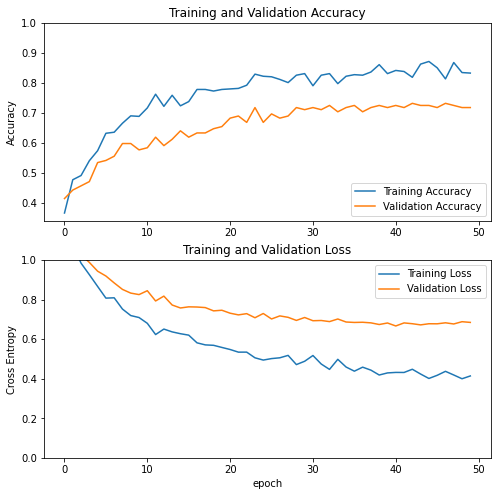

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning
* One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

#### Un-freeze the top layers of the model

* All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.


In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### Compile the model

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20),
    keras.callbacks.ModelCheckpoint(
    filepath='vgg19_standart.h5',
    monitor='val_accuracy',
    save_best_only=True)
]

In [33]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_set,
                         callbacks= callbacks_list)

Epoch 50/80
18/18 [==============================] - 91s 5s/step - loss: 0.2401 - accuracy: 0.9121 - val_loss: 0.5256 - val_accuracy: 0.7746
Epoch 51/80
18/18 [==============================] - 88s 5s/step - loss: 0.2173 - accuracy: 0.9209 - val_loss: 0.5059 - val_accuracy: 0.7676
Epoch 52/80
18/18 [==============================] - 58s 3s/step - loss: 0.1553 - accuracy: 0.9543 - val_loss: 0.5393 - val_accuracy: 0.8028
Epoch 53/80
18/18 [==============================] - 89s 5s/step - loss: 0.1134 - accuracy: 0.9666 - val_loss: 0.5670 - val_accuracy: 0.7958
Epoch 54/80
18/18 [==============================] - 90s 5s/step - loss: 0.1425 - accuracy: 0.9420 - val_loss: 0.6502 - val_accuracy: 0.7887
Epoch 55/80
18/18 [==============================] - 62s 3s/step - loss: 0.1124 - accuracy: 0.9666 - val_loss: 0.5464 - val_accuracy: 0.7817
Epoch 56/80
18/18 [==============================] - 63s 3s/step - loss: 0.0916 - accuracy: 0.9631 - val_loss: 0.5842 - val_accuracy: 0.8028
Epoch 57/80
1

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

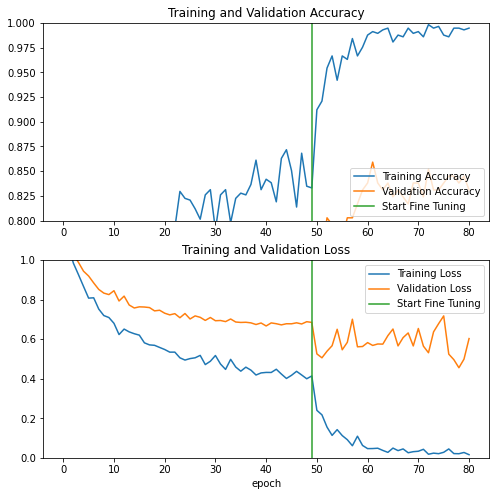

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction
* Finally you can verify the performance of the model on new data using test set.

In [36]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_set)[1]*100))

3/3 [==============================] - 5s 2s/step - loss: 0.5762 - accuracy: 0.8478
We got an accuracy of 84.78%


In [37]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)

3/3 [==============================] - 5s 2s/step - loss: 0.5762 - accuracy: 0.8478
Test accuracy : 0.8478260636329651


In [38]:
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_pred = []
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

Labels:
 [1 0 0 0 2 0 0 2 0 2 1 1 1 2 1 1 2 2 2 1 1 0 1 0 0 2 0 0 1 0 0 1]
Predictions:
 [1 0 1 0 2 0 0 2 1 1 1 1 1 2 1 1 2 0 2 1 1 0 1 0 2 2 0 0 1 0 0 1]


### Results

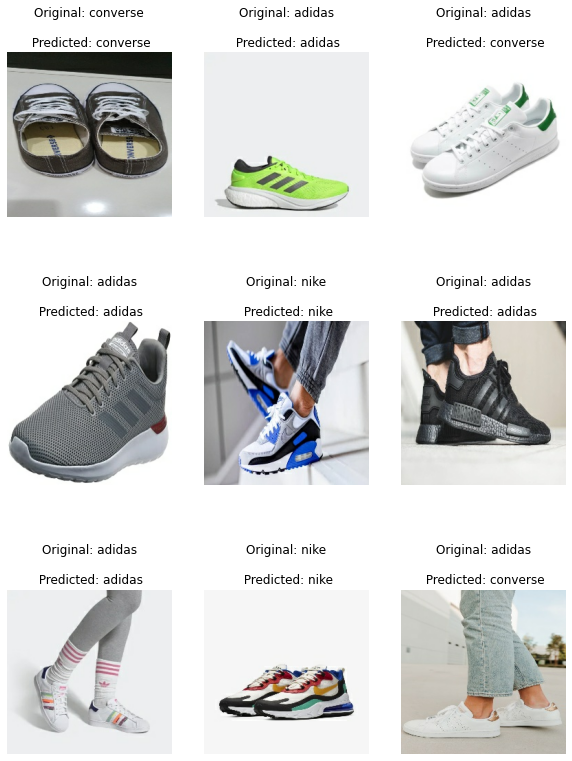

In [39]:
plt.figure(figsize=(10, 14))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Original: {class_names[label_batch[i]]}\n\n Predicted: {class_names[y_pred[i]]}")
    plt.axis("off")

### Confusion Matrix

In [68]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

pred = model.predict(test_set)
predictions = argmax(pred, axis=1) # return to label

4/4 [==============================] - 2s 513ms/step


In [69]:
predictions

array([2, 1, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1,
       1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0,
       1, 0, 2, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 2, 0, 1, 1,
       0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 1, 2, 0, 1,
       0, 2, 2, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1,
       0, 0, 0, 2], dtype=int64)

Labels:
 [1 0 0 0 2 0 0 2 0 2 1 1 1 2 1 1 2 2 2 1 1 0 1 0 0 2 0 0 1 0 0 1]
Predictions:
 [1 0 1 0 2 0 0 2 1 1 1 1 1 2 1 1 2 0 2 1 1 0 1 0 2 2 0 0 1 0 0 1]


<ipython-input-73-4e14c7594a5a>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_names)
<ipython-input-73-4e14c7594a5a>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_names)


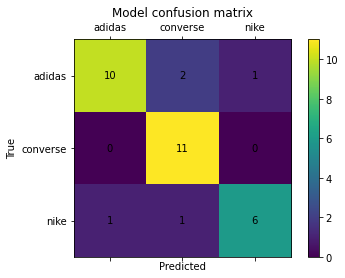

Accuracy : 84.38%
              precision    recall  f1-score   support

      adidas       0.91      0.77      0.83        13
    converse       0.79      1.00      0.88        11
        nike       0.86      0.75      0.80         8

    accuracy                           0.84        32
   macro avg       0.85      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32



In [73]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

#pred = model.predict(image_batch)
y_pred = []
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

cm = confusion_matrix(label_batch, y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(3):
    for j in range(3):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(label_batch, y_pred)
print("Accuracy : %.2f%%" % (accuracy*100.0))

print(classification_report(label_batch, y_pred, target_names=class_names))